# Requirements for Public Key Signatures in Bitcoin

Bitcoin is a ledger which uses public key cryptography to allow the following to happen:
- Bob wishes to receive money from Alice, then have the optionality to spend it later, but without anybody else able to spend his money.
- Using public key encryption, Bob creates a public key/private key pair, and uses his public key to give Alice an address as the destination to receive the funds.
- Later on, Bob can sign transactions from the public key address using his private key.
- The algorithms are chosen to make it easy to derive a public key from a private key, but not the reverse. Therefore nobody else can derive Bob's private key and spend his money.

Mathematically, this looks like the following:
\begin{align*}
\text{private key} &= d_B \\
\text{public key} &= Q_B = f_\text{one-way}(d_B) \\
\text{message} &= m \\
\text{signature} &= s = f_\text{sign}(m, d_B) \\
\text{verification} &= f_\text{verify}(m, Q_B, s) \in \{0, 1\}
\end{align*}

Bob would broadcast $Q_B$ ahead of time and would be used by Alice to send funds to Bob. Then later Bob would spend from this address by creating a message $m$ which contains the source address, destination address, amount, and fees. Since only Bob has $d_B$, only he can produce the correct signature $s$, which everyone else in the network can check with $f_\text{verify}$.

(Note: in Bitcoin, the address is not the public key itself, but rather a hash of the public key. However the public key is still revealed when Bob spends his bitcoin, and everyone can check that $\text{HASH}(Q_B)$ matches the spending address).

How can such a scheme be implemented? Bitcoin uses ECDSA, the [Elliptic Curve Digital Signature Algorithm](https://en.wikipedia.org/wiki/Elliptic_Curve_Digital_Signature_Algorithm). To understand ECDSA, it is first necessary to understand how the addition and multiplication operations work within the context of elliptic curves.

# Elliptic Curves

Elliptic curves are equations of the following form.
$$y^2 = x^3 + ax + b ~\text{over}~(\mathbb{F}_p)$$
The field $\mathbb{F}_p$ is quite general and can be anything from the reals, to rationals, to integers, to integers mod p.

Below is an example of an elliptic curve in which a=-4, b=4, and $\mathbb{F}_p$ is over the reals.

c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


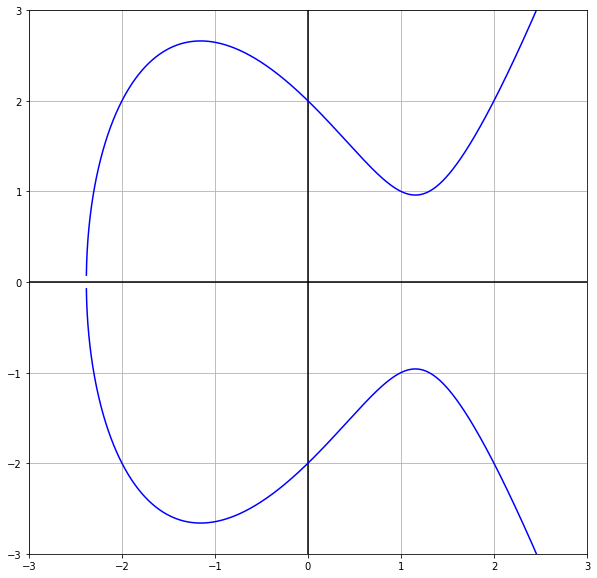

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.set_yticks(np.linspace(-4, 4, 9))
ax.set_xticks(np.linspace(-3, 3, 7))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

a=-4
b=4
min_x = -3
max_x = 3
num_x = 10000

x = np.linspace(min_x, max_x, num_x)
y_top = np.sqrt(x**3+a*x+b)
y_bottom = -np.sqrt(x**3+a*x+b)

ax.plot(x, y_top, color='b')
ax.plot(x, y_bottom, color='b')

# Mathematical Operations

We can use elliptic curves to define special versions of "addition" and "multiplication", but instead of adding numbers, we add together points which lie on a particular elliptic curve.
Although these operations are quite different from their numerical counterparts, they satisfy similar properties such as associativity and commutivity.
In mathematical speak, points on an elliptic curve form a "Group".

# Definition of Elliptic Curve Addition

Addition of two points $P_1=(x_1,y_1)$ and $P_2=(x_2,y_2)$ is defined as follows.

1. Draw the line joining $P_1$ and $P_2$ and calculate its slope $\lambda$.
2. Find the third point where this line intersects the curve $P_3' = (x_3', y_3')$.
3. Flip over the x-axis to get $P_3 = (x_3, y_3) = (x_3', -y_3')$. Note $P_3$ also lies on the curve because of the $y$-symmetry in the elliptic curve definition.

It can be shown that $P_3$ is calculated from the [following formula](https://en.wikipedia.org/wiki/Elliptic_curve_point_multiplication#Point_addition).
\begin{align*}
& \lambda=(y_2-y_1)/(x_2-x_1) \\
& x_3 = \lambda^2 - x_1 - x_2 \\
& y_3 = \lambda (x_1 - x_3) - y_1
\end{align*}

Returning to our example curve where $a=-4$ and $b=4$, suppose $P_1=(-2,-2)$ and $P_2=(1,1)$. Then straightforward substitution can solve for $P_3$.
\begin{align*}
& \lambda = (1 - (-2))/(1 - (-2)) = 3/3 = 1 \\
& x_3 = 1^2 - (-2) - 1 = 2 \\
& y_3 = 1 \times(-2 - 2) - (-2) = -2
\end{align*}

A visual representation is shown below.

c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


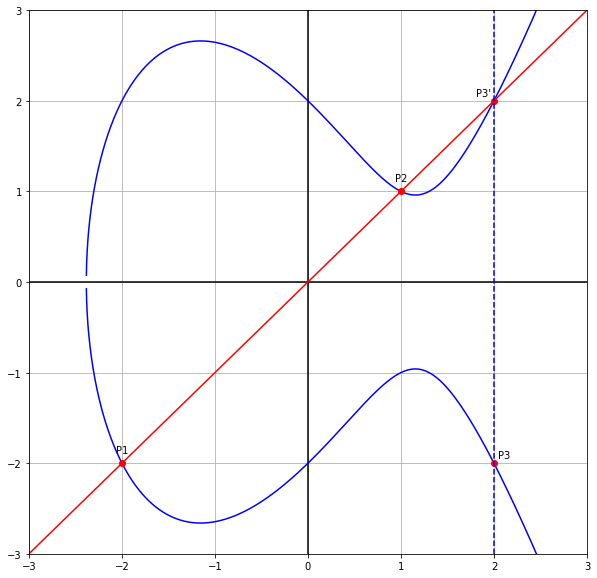

In [13]:
import numpy as np
import matplotlib.pyplot as plt

a=-4
b=4
min_x = -3
max_x = 3
num_x = 10000
x1 = -2
y1 = -2
x2 = 1
y2 = 1
P1_offset = (0,10)
P2_offset = (0,10)
P3_p_offset = (-10,5)
P3_offset = (10,5)

x = np.linspace(min_x, max_x, num_x)
y_top = np.sqrt(x**3+a*x+b)
y_bottom = -np.sqrt(x**3+a*x+b)

_lambda = (y2 - y1) / (x2 - x1)
x3 = _lambda**2 - x1 - x2
y3 = _lambda*(x1 - x3) - y1
x3_p = x3
y3_p = -y3

fig, ax = plt.subplots(figsize=(10,10))
ax.axhline(0, color='k')
ax.axvline(0, color='k')

ax.set_yticks(np.linspace(-4, 4, 9))
ax.set_xticks(np.linspace(-3, 3, 7))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

ax.plot(x, y_top, color='b')
ax.plot(x, y_bottom, color='b')

ax.plot(x1, y1, marker='o', color='r')
ax.annotate('P1', (x1, y1), textcoords='offset points', xytext=P1_offset, ha='center')
ax.plot(x2, y2, marker='o', color='r')
ax.annotate('P2', (x2, y2), textcoords='offset points', xytext=P2_offset, ha='center')
ax.plot(x3_p, y3_p, marker='o', color='r')
ax.annotate('P3\'', (x3_p, y3_p), textcoords='offset points', xytext=P3_p_offset, ha='center')
ax.plot(x3, y3, marker='o', color='r')
ax.annotate('P3', (x3, y3), textcoords='offset points', xytext=P3_offset, ha='center')

_lambda = (y2-y1)/(x2-x1)
y_lambda = _lambda*(x-x1)+y1
ax.plot(x, y_lambda, color='r')

plt.axvline(2, linestyle='--', color='b')

# Addition of The Same Point

Suppose we are adding a point to itself $P_2 = P_1 + P_1$.
The procedure is similar to before, except $\lambda$ is calculated using the slope of the line tangent to $P_1$. The slope of the elliptic curve can be derived using calculus.
\begin{align*}
& y^2 = x^3 + ax + b \\
& 2y dy = (3x^2 + a)dx \\
& \frac{dy}{dx} = \frac{3x^2 + a}{2y}
\end{align*}
Therefore $\lambda$ and $P_2$ is given by the following.
\begin{align*}
& \lambda = \frac{3x_1^2 + a}{2y_1} \\
& x_2 = \lambda^2 - 2 x_1 \\
& y_2 = \lambda (x_1 - x_2) - y_1
\end{align*}

As an example, suppose we add $P_1=(-2, -2)$ to itself. 
\begin{align*}
& \lambda = \frac{3(-2)^2 - 4}{2(-2)} = \frac{8}{-4} = -2 \\
& x_2 = (-2)^2 - 2(-2) = 8 \\
& y_2 = -2(-2-8) - (-2) = 20+4 = 24
\end{align*}

This is shown visually below.

c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt
c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


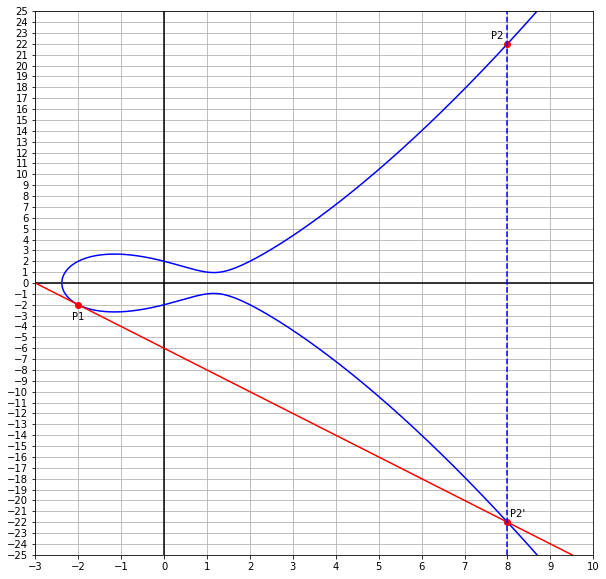

In [18]:
import numpy as np
import matplotlib.pyplot as plt

a=-4
b=4
min_x = -3
max_x = 10
num_x = 10000
x1 = -2
y1 = -2
P1_offset = (0, -15)
P2_p_offset = (10, 5)
P2_offset = (-10, 5)

_lambda = (3*x1**2 + a)/(2*y1)
x2 = _lambda**2 - 2*x1
y2 = _lambda*(x1-x2) - y1
x2_p = x2
y2_p = -y2

fig, ax = plt.subplots(figsize=(10,10))
ax.axhline(0, color='k')
ax.axvline(0, color='k')

ax.set_yticks(np.linspace(-25, 25, 51))
ax.set_xticks(np.linspace(-3, 10, 14))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_xlim([-3, 10])
ax.set_ylim([-25, 25])

x = np.linspace(min_x, max_x, num_x)
y_top = np.sqrt(x**3+a*x+b)
y_bottom = -np.sqrt(x**3+a*x+b)
ax.plot(x, y_top, color='b')
ax.plot(x, y_bottom, color='b')

ax.plot(x1, y1, marker='o', color='r')
ax.annotate('P1', (x1, y1), textcoords='offset points', xytext=P1_offset, ha='center')
ax.plot(x2_p, y2_p, marker='o', color='r')
ax.annotate('P2\'', (x2_p, y2_p), textcoords='offset points', xytext=P2_p_offset, ha='center')
ax.plot(x2, y2, marker='o', color='r')
ax.annotate('P2', (x2, y2), textcoords='offset points', xytext=P2_offset, ha='center')

y_lambda = _lambda*(x-x1)+y1
ax.plot(x, y_lambda, color='r')

ax.axvline(x2, linestyle='--', color='b')

# Point at Infinity

Within the context of elliptic curve addition, there is a special point $\mathcal O$ which is the identity point for addition. It doesn't actually exist anywhere on the curve itself, but rather is added as a postulate to the domain of the group. It is sometmes called "the point at infinity", as it appears when intersecting lines of infinite slope.

The identity point satisfies the following properties.
\begin{align*}
\mathcal O + P &= P + \mathcal O = P \\
\mathcal O + \mathcal O &= \mathcal O
\end{align*}

In the figure below, note how adding $P=(x,y)$ to the point at $\mathcal O=(x,\infty)$ would draw a line to $P'=(x,-y)$, and then flipping across the x-axis would return to the original point $P=(x,y)$, hence satisfying $P + \mathcal O = P$.

# Point Negation

The negative of a point $P=(x, y)$ is defined as flipping the point over the x-axis $-P=(x, -y)$. Since the curve has y-axis symmetry, this point must lie on the curve. Point negation and the point at infinity satisfy the following relation.
$$P + (-P) = \mathcal O$$

In the figure below, note how adding $P=(x,y)$ to $-P=(x,-y)$ creates a line with infinite slope, which approaches $\mathcal O=(x,\infty)$, hence satisfying $P + (-P) = \mathcal O$.

c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
c:\users\scott\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


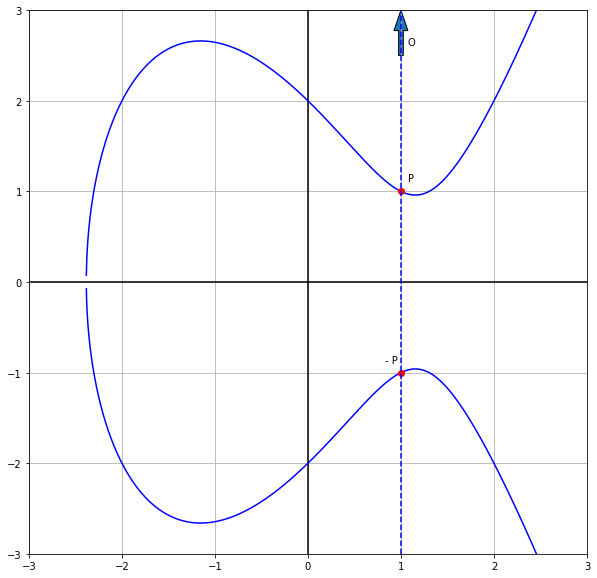

In [28]:
import numpy as np
import matplotlib.pyplot as plt

a=-4
b=4
min_x = -3
max_x = 3
num_x = 10000
x1 = 1
y1 = 1
x1_p = 1
y1_p = -1
P1_offset = (10, 10)
P1_p_offset = (-10, 10)
O_x = 1
O_y = 2.5
O_dx = 0
O_dy = 0.5
O_offset = (10, 10)

x = np.linspace(min_x, max_x, num_x)
y_top = np.sqrt(x**3+a*x+b)
y_bottom = -np.sqrt(x**3+a*x+b)

fig, ax = plt.subplots(figsize=(10,10))
ax.axhline(0, color='k')
ax.axvline(0, color='k')

ax.set_yticks(np.linspace(-4, 4, 9))
ax.set_xticks(np.linspace(-3, 3, 7))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

ax.plot(x, y_top, color='b')
ax.plot(x, y_bottom, color='b')

ax.plot(x1, y1, marker='o', color='r')
ax.annotate('P', (x1, y1), textcoords='offset points', xytext=P1_offset, ha='center')
ax.plot(x1_p, y1_p, marker='o', color='r')
ax.annotate('- P', (x1_p, y1_p), textcoords='offset points', xytext=P1_p_offset, ha='center')
ax.arrow(O_x, O_y, O_dx, O_dy, length_includes_head=True, width=0.05)
ax.annotate('O', (O_x, O_y), textcoords='offset points', xytext=O_offset, ha='center')

plt.axvline(1, linestyle='--', color='b')

# Multiplication

Multiplication over elliptic curves is defined as repeated self-addition. Note that multiplication is between a scalar and a point, unlike addition which is between two points.
$$P_k = k \times P_1 = \underbrace{P_1+\ldots+P_1}_{k}$$
Recall that elliptic curve addition is both associative and commutative.

\begin{align*}
\text{Commutativity: }& P + Q = Q + P \\
\text{Associativity: }& (P + Q) + R = P + (Q + R)
\end{align*}

Because of the associativity rule, large multiplications can be calculated quickly with powers of 2. For example, when calculating $P_4$, it is possible to cache $P_2$ and add it to itself, resulting in two required operations instead of three.

$$P_4 = P_1 + P_1 + P_1 + P_1 = (P_1 + P_1) + (P_1 + P_1) = P_2 + P_2$$

Scaling up, it is possible to calculate $P_{48}$ with only 7 calculations instead of 48.

\begin{align*}
& P_{16} = 2^4 \times P_1 = 2 \times (2 \times (2 \times (2 \times P_1))) \\
& P_{32} = 2 \times P_16 \\
& P_{48} = P_{32} + P_{16}
\end{align*}

Multiplication will be important later on for the encryption scheme.

# Modular Elliptic Curves

So far we've seen elliptic curves over real numbers, but they also exist over integers mod N.
For example, the following elliptic curve is used for bitcoin's encryption scheme, where p is some fixed prime number.
$$y^2 = x^3 + 7 \mod p$$
When doing point addition, each intermediate step is performed under mod $p$.

\begin{align*}
\text{(unique point addition) } & \lambda=\frac{y_2-y_1}{x_2-x_1} \mod p \\
\text{(self-addition) } & \lambda = \frac{3x^2 + a}{2y_1} \mod p \\
& x_3 = \lambda^2 - x_1 - x_2 \mod p\\
& y_3 = \lambda (x_1 - x_3) - y_1 \mod p
\end{align*}

Division under modular arithmetic is a little tricky and requires finding the inverse under mod $p$.

\begin{align*}
a / b &= a \times (b^{-1}) \mod p \\
b^{-1} &= k \text{ such that } k \times b = 1 \mod p
\end{align*}

To see what this looks like, the plot below shows $p=17$ and $P_1=(15,4)$. Note that the final point is $P_{17} = (15,13)$, which if added back to $P_1$ gives the point at infinity. Also note there is a [fast algorithm](https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm) to find the inverse, but the code below just uses the naive method of trying each value until one works.

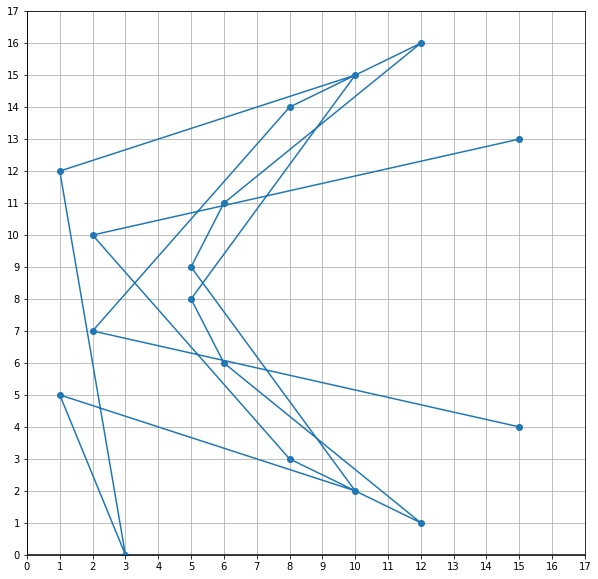

In [46]:
import numpy as np
import matplotlib.pyplot as plt

a=0
b=7
p=17
x1 = 15
y1 = 4

xk = x1
yk = y1
xks = [x1]
yks = [y1]

def mod_divide(num, dem):
    for i in range(p):
        if ((dem*i)%p)==(num%p):
            return i
    raise RuntimeError

for i in range(p-1):
    if (x1==xk) and (y1==yk):
        _lambda = (((3*xk**2)%p) * mod_divide(1, 2*yk))%p
    else:
        _lambda = ((yk - y1) * mod_divide(1, xk - x1))%p
    xk = (_lambda**2 - x1 - xk)%p
    yk = (_lambda*(x1-xk) - y1)%p
    xks.append(xk)
    yks.append(yk)

fig, ax = plt.subplots(figsize=(10,10))
ax.axhline(0, color='k')
ax.axvline(0, color='k')

ax.set_yticks(np.linspace(0, 17, 18))
ax.set_xticks(np.linspace(0, 17, 18))
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='major')
ax.set_xlim([0, 17])
ax.set_ylim([0, 17])

ax.plot(xks, yks, marker='o')
        

# Digital Signing Algorithm

The Elliptic Curve used by Bitcoin has a very large prime order. 

\begin{align*}
p &= 2^{256} - 2^{32} - 2^9 - 2^8 - 2^7 - 2^6 - 2^4 - 1 \\
p &= \text{FFFFFFFF FFFFFFFF FFFFFFFF FFFFFFFF FFFFFFFF FFFFFFFF FFFFFFFE FFFFFC2F}
\end{align*}

The exact specification for signing is given by [secp256k1](https://en.bitcoin.it/wiki/Secp256k1). The first step is to define a Generator Point $G$ which is used for deriving other points in the encryption scheme. For secp256k1, the generator point is defined as the following.

$$G=(G_x, G_y) = \\(\text{02 79BE667E F9DCBBAC 55A06295 CE870B07 029BFCDB 2DCE28D9 59F2815B 16F81798}, \text{483ADA77 26A3C465 5DA4FBFC 0E1108A8 FD17B448 A6855419 9C47D08F FB10D4B8})$$

Given a modular elliptic curve and generator point $G$, there is a number called the order $n$ of $G$, which is how many self-additions are needed to reach the identity point $\mathcal O$. In other words, $n \times G = \mathcal O$. For secp256k1, the order is the following.

$$n = \text{FFFFFFFF FFFFFFFF FFFFFFFF FFFFFFFE BAAEDCE6 AF48A03B BFD25E8C D0364141}$$

# Creating a private/public key pair

Suppose Alice wants to create a private/public key pair. To create a private key, Alice generates a cryptographically secure random number $d_A$ in the interval $[1, n-1]$. Then to create the corresponding public key $Q_A$, Alice multiplies $G$ by $d_A$.

\begin{align*}
\text{private key (number): } & d_A \in [1, n-1] \\
\text{public key (point): } & Q_A = d_A \times G
\end{align*}

Alice is free to broadcast $Q_A$ since calculating $d_A$ given $Q_A$ and $G$ is a variant of the [Discrete Log Problem](https://en.wikipedia.org/wiki/Discrete_logarithm), which is computationally intractable.

# Signing a message

To sign a message, Alice first creates a cryptographically secure random number $k \in [1, n-1]$. It is important that she keeps $k$ a secret and generates a new one for each signature. She then calculates $R = k \times G$ and takes the x-coordinate of this point, which we call $r$. $r$ will be publically revealed later as part of the signature. Note the similarity between $Q_A=d_A \times G$ and $R=k \times G$ and how $Q_A$/$R$ are made public while $d_A$/$k$ are kept private.

The idea is to mix $d_A$, $k$, and $m$ into a new number $s$ in such a way that when we reveal $s$ and $r$, everyone else can verify using $Q_A$ that $s$ and $r$ were produced with the matching $d_A$, $k$, and $m$. The formula for $s$ is the following.

$$s = (r d_A + m) k^{-1} \mod n$$

# Verifying a message

Suppose Bob is verifying Alice's signature. To verify the signature, Bob calculates two new points $m s^{-1} \times G$ and $r s^{-1} \times Q_A$. If everything works correctly, when these are added together, this should output the point $R$. He can then take the x-coordinate and compare it with $r$.

The math works as follows.

\begin{align*}
& m s^{-1} \times G + r s^{-1} \times Q_A \\
& m s^{-1} \times G + r s^{-1} d_A \times G \\
& (m + r d_A) s^{-1} \times G \\
& (m + r d_A) (k^{-1} (m + r d_A)) ^ {-1} \times G \\
& k \times G \\
& R
\end{align*}

If someone tried to forge $s$ they would need it to perfectly cancel the $(m + r d_A)$ which wouldn't work unless they knew the original $d_A$ (at least that's how I think this works).